In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

c:\Users\ivan.trujillo_blueta\proyectos\personal\flood_prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.shape, test.shape

((1117957, 22), (745305, 21))

In [5]:
train.head().T

,0,1,2,3,4
id,0.000,1.00,2.00,3.000,4.000
MonsoonIntensity,5.000,6.00,6.00,3.000,5.000
TopographyDrainage,8.000,7.00,5.00,4.000,3.000
RiverManagement,5.000,4.00,6.00,6.000,2.000
Deforestation,8.000,4.00,7.00,5.000,6.000
Urbanization,6.000,8.00,3.00,4.000,4.000
ClimateChange,4.000,8.00,7.00,8.000,4.000
DamsQuality,4.000,3.00,1.00,4.000,3.000
Siltation,3.000,5.00,5.00,7.000,3.000
AgriculturalPractices,3.000,4.00,4.00,6.000,3.000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1117957.0,558978.000000,322726.531784,0.000,279489.00,558978.000,838467.00,1117956.000
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000


In [9]:
train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [10]:
test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>],
       [<Axes: title={'center': 'Urbanization'}>,
        <Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>],
       [<Axes: title={'center': 'Encroachments'}>,
        <Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>],
       [<Axes: title={'center': 'Watersheds'}>,
        <Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLo

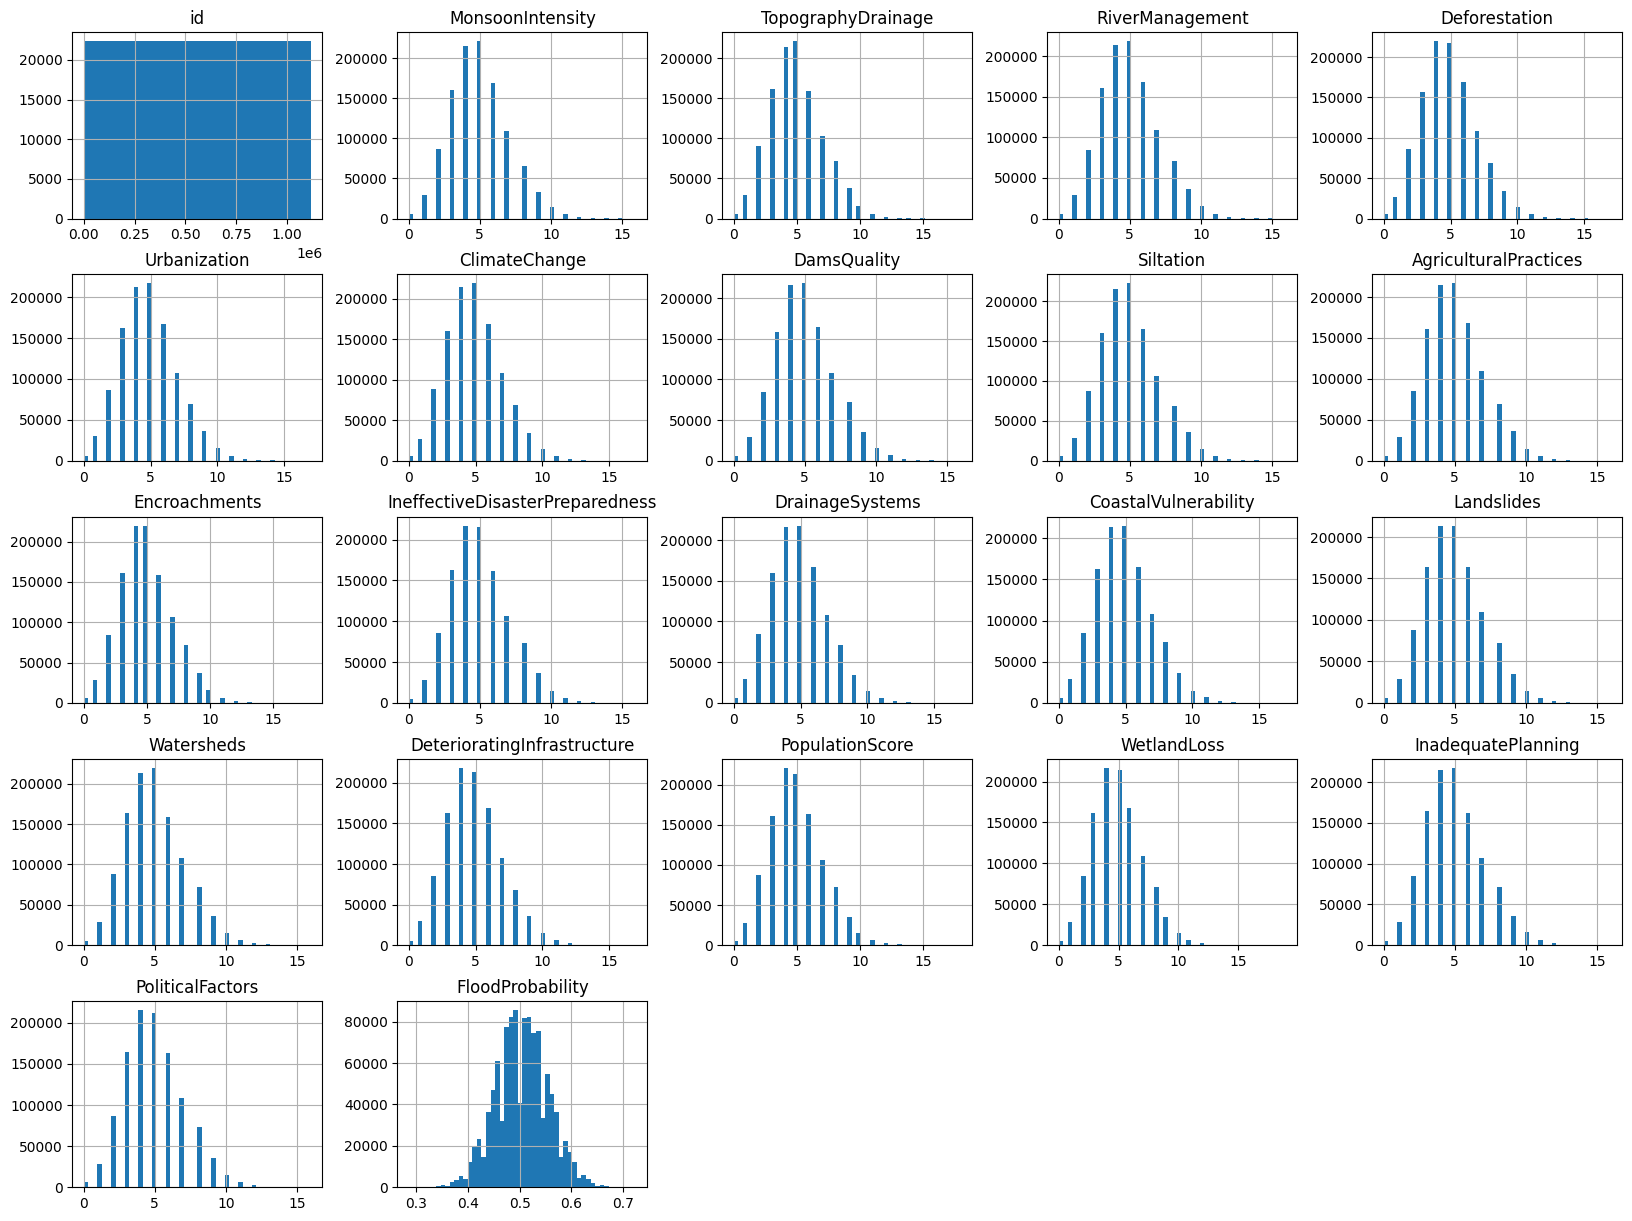

In [11]:
train.hist(bins=50, figsize=(20, 15))

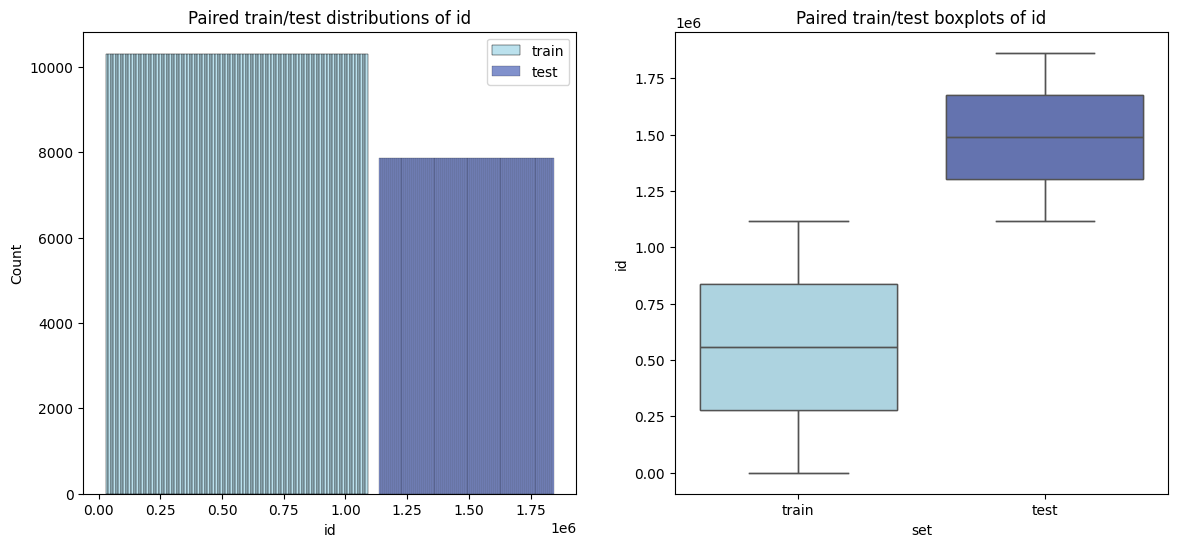

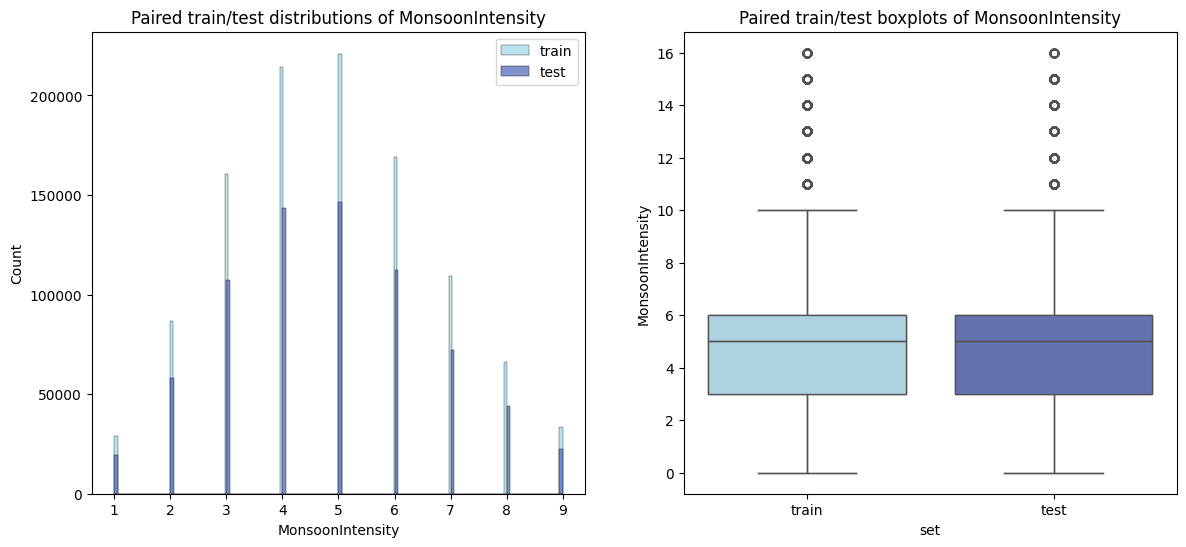

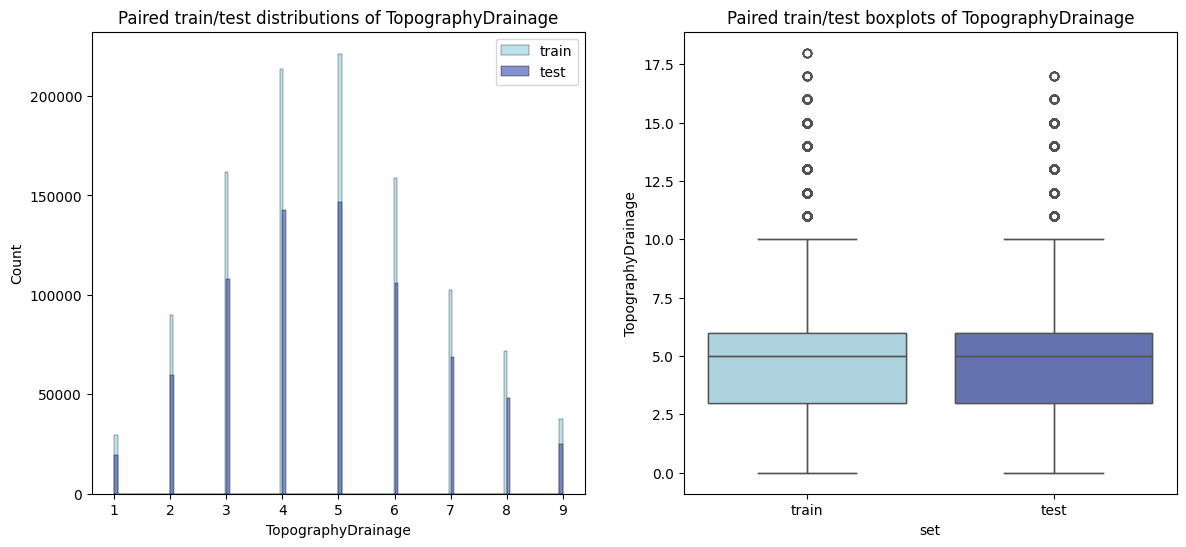

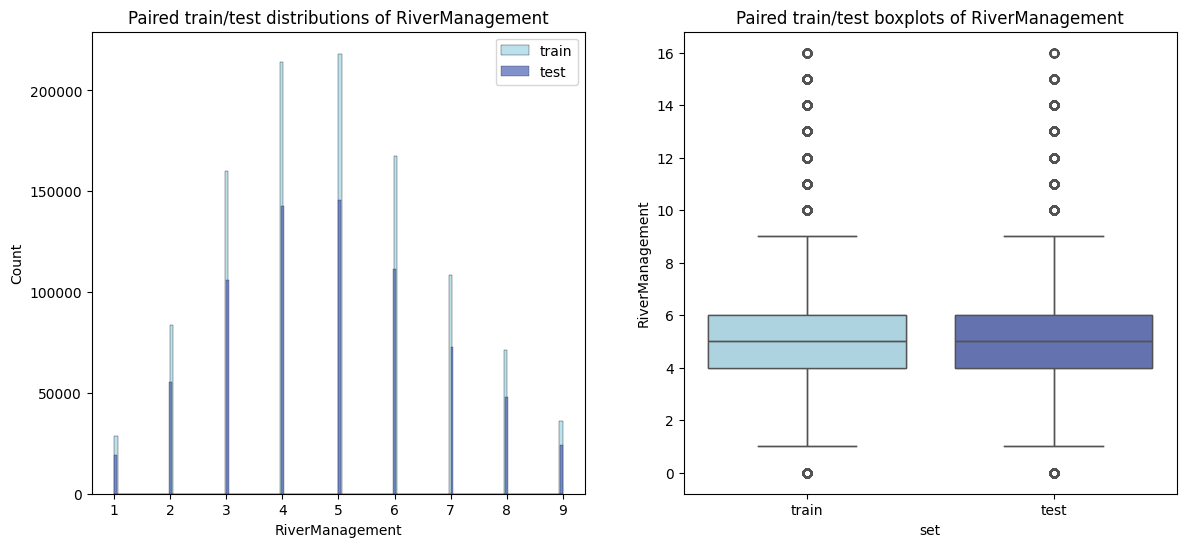

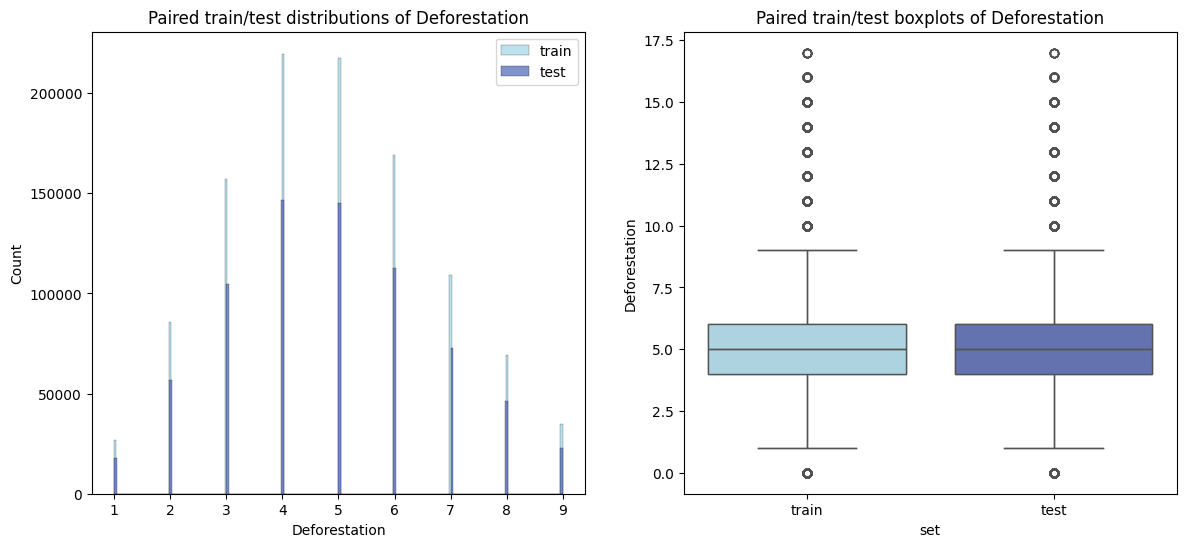

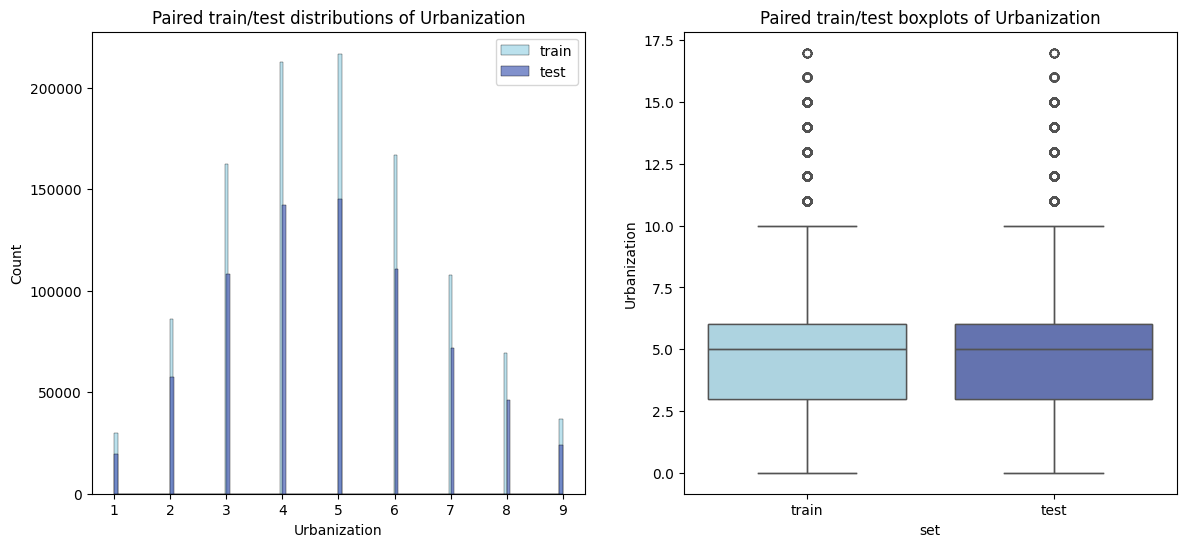

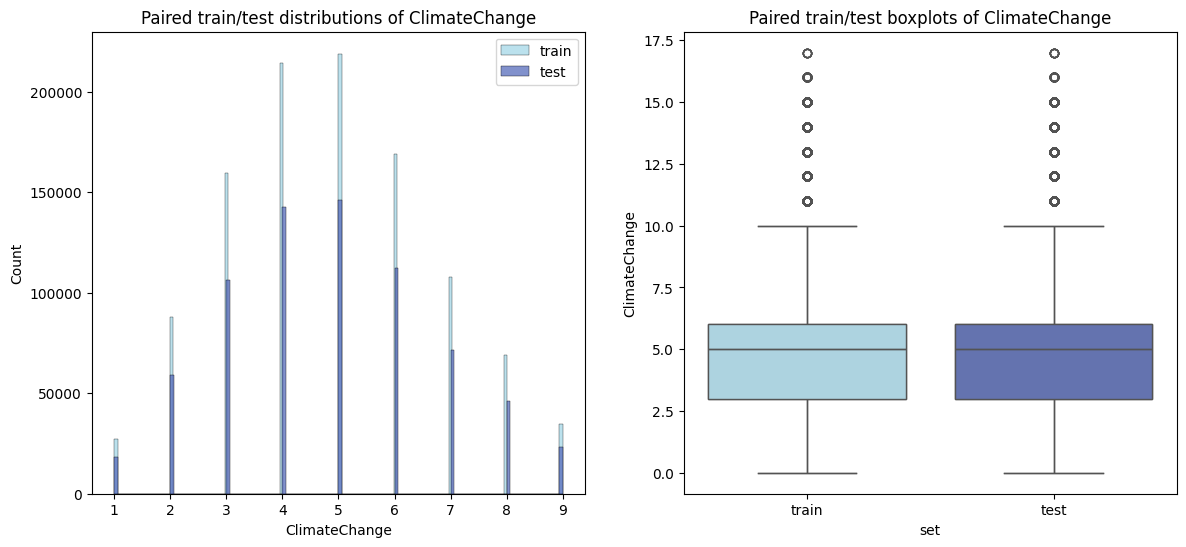

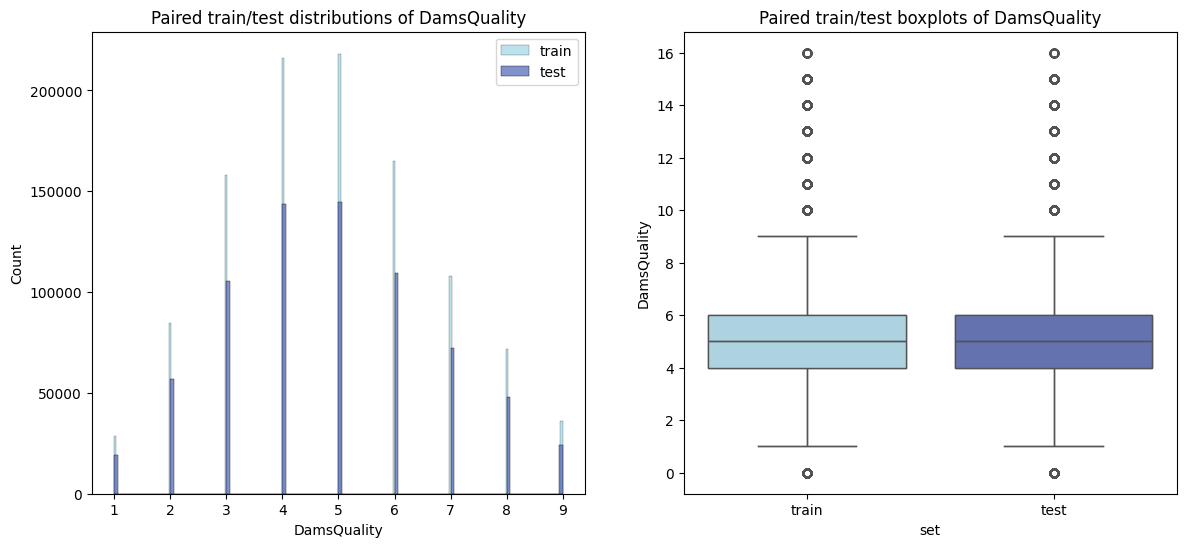

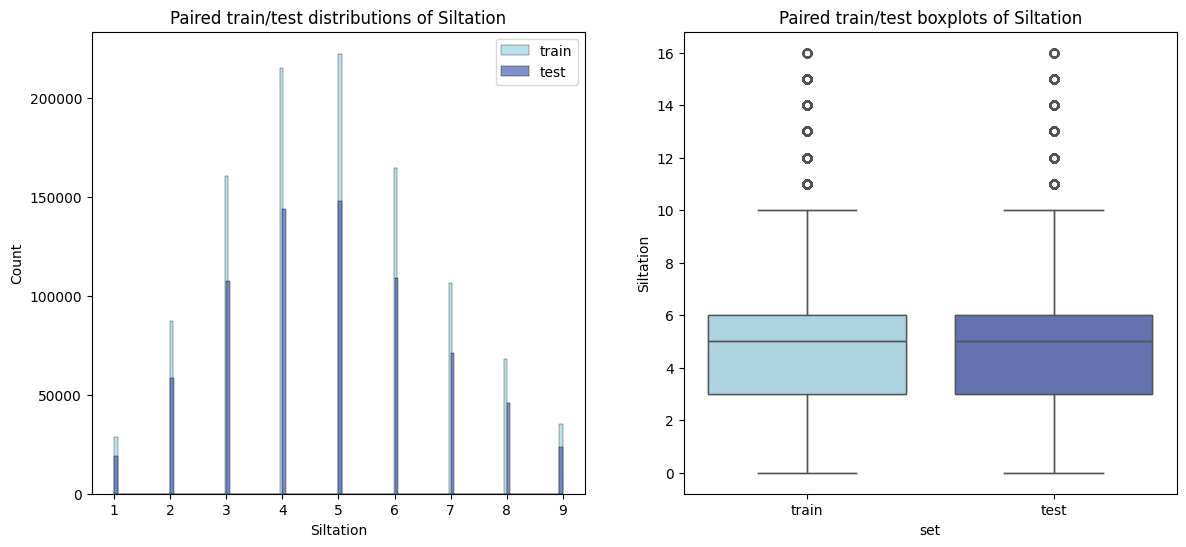

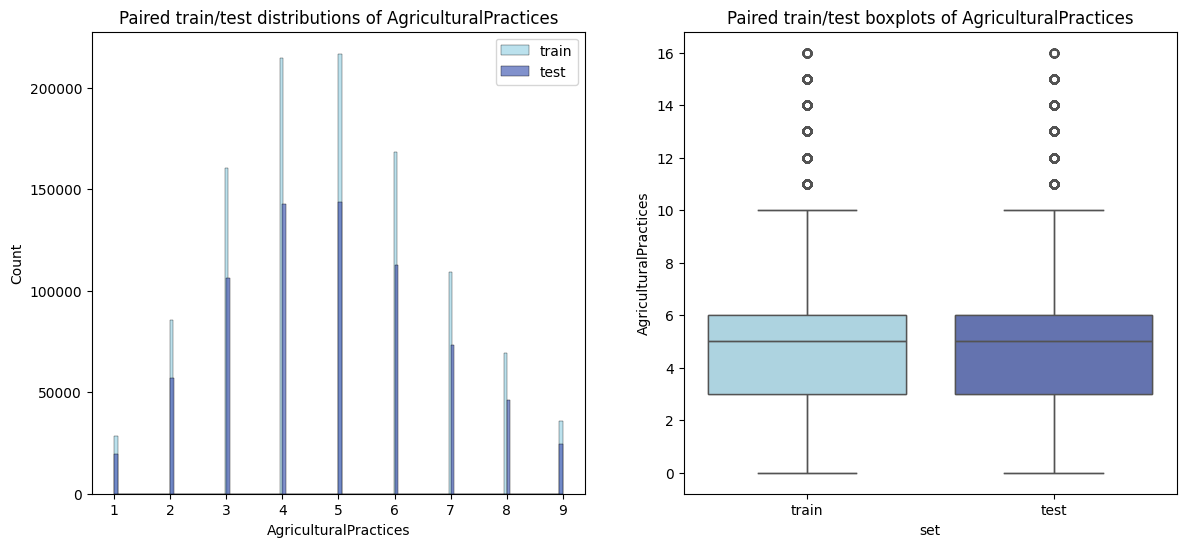

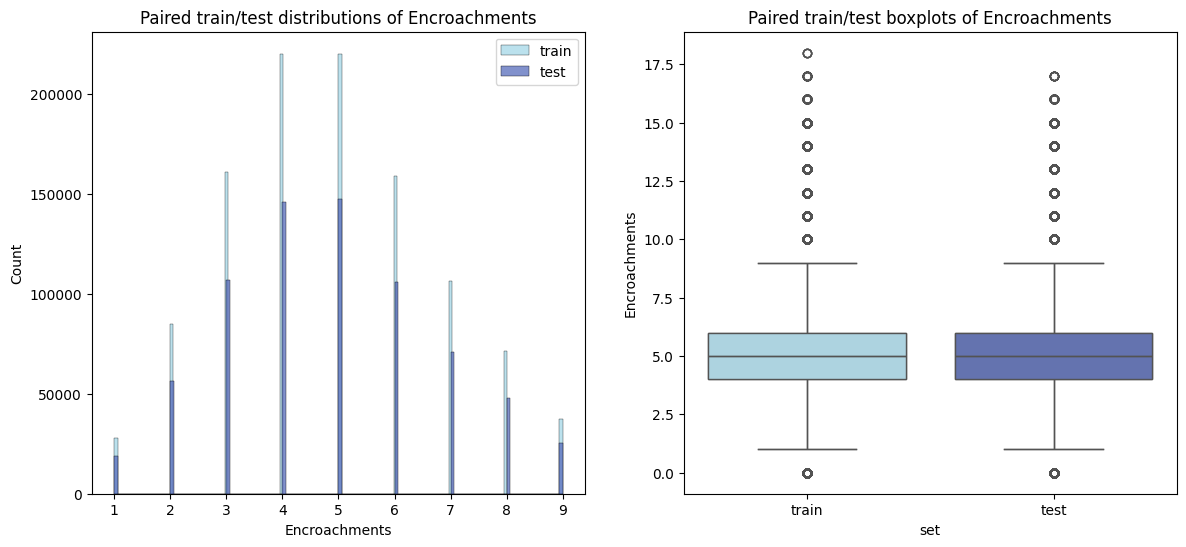

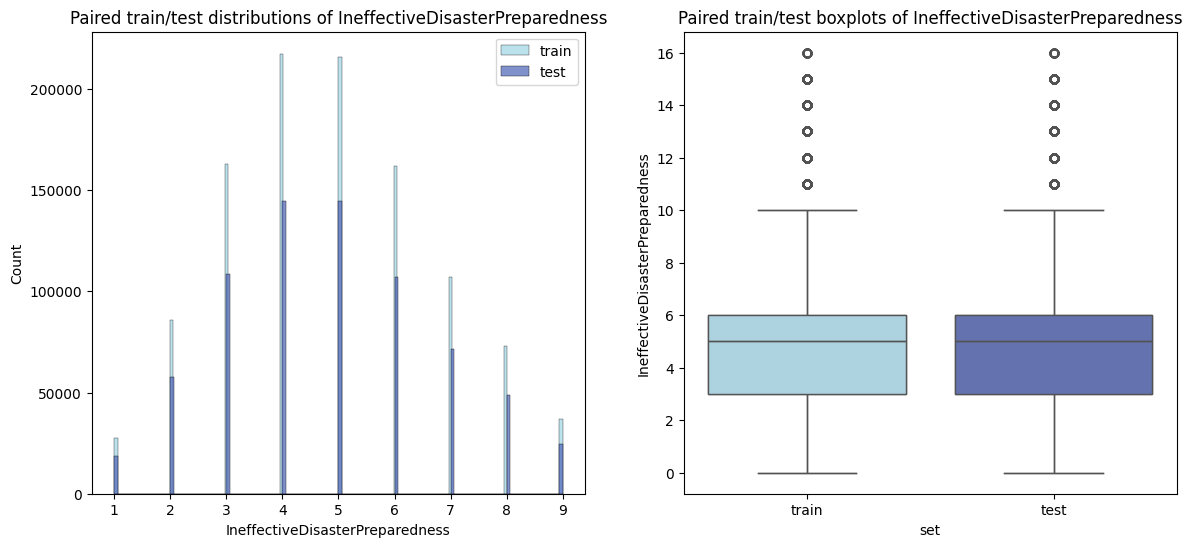

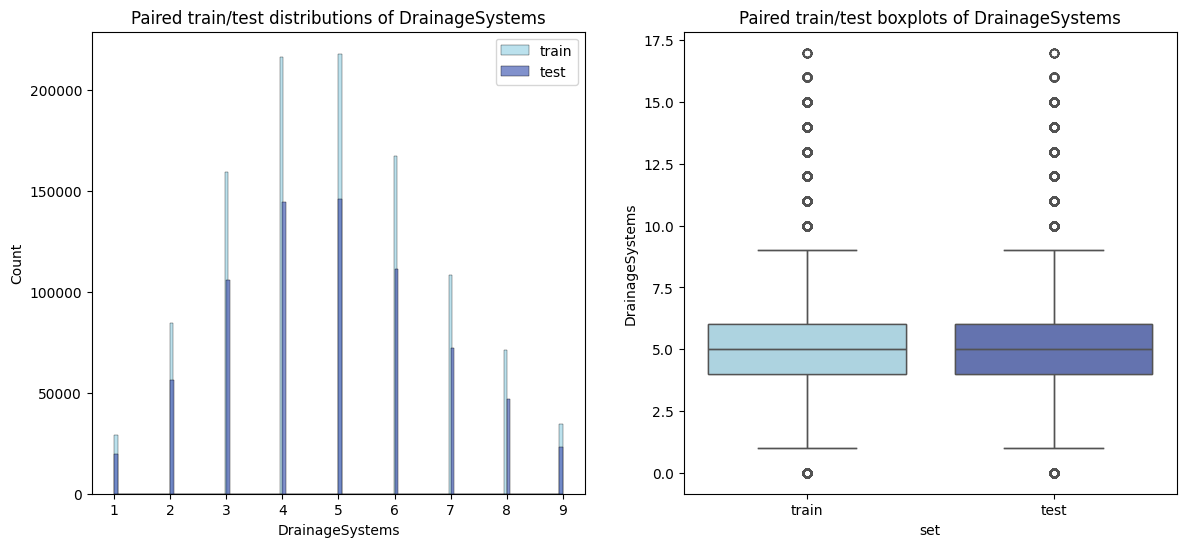

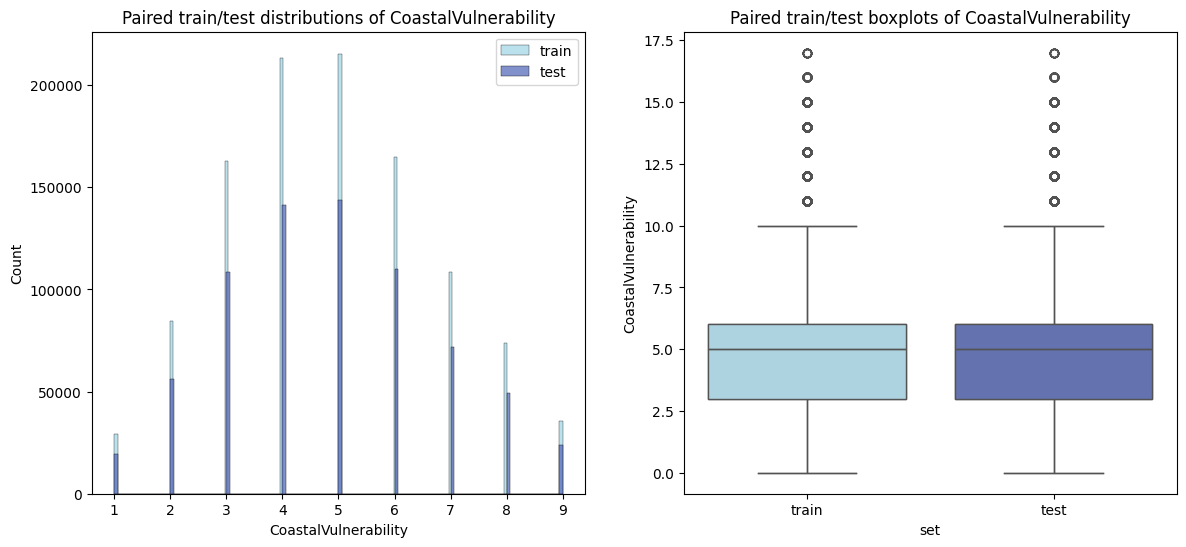

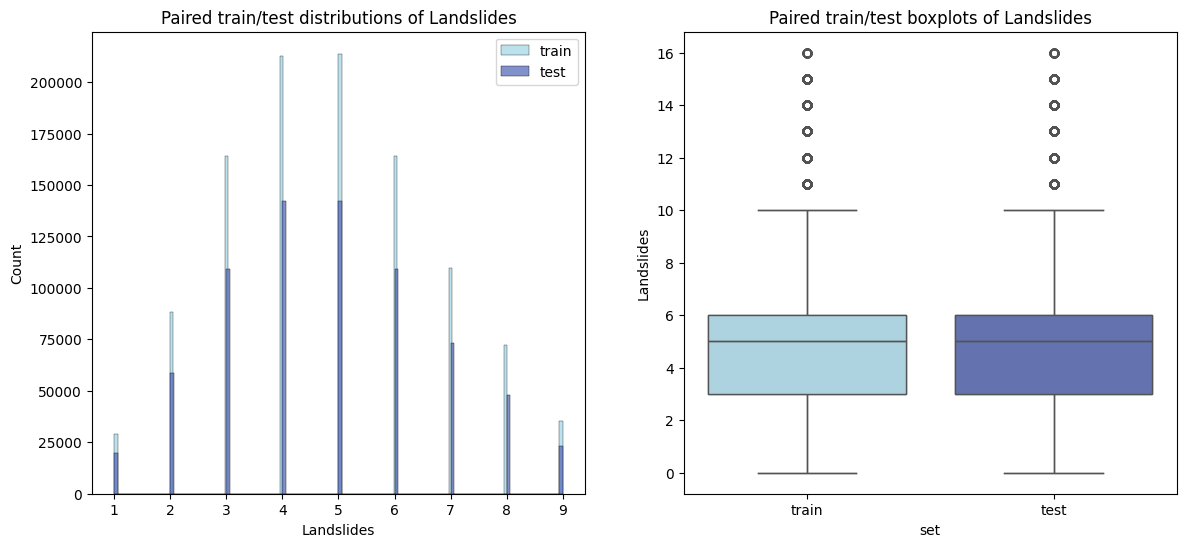

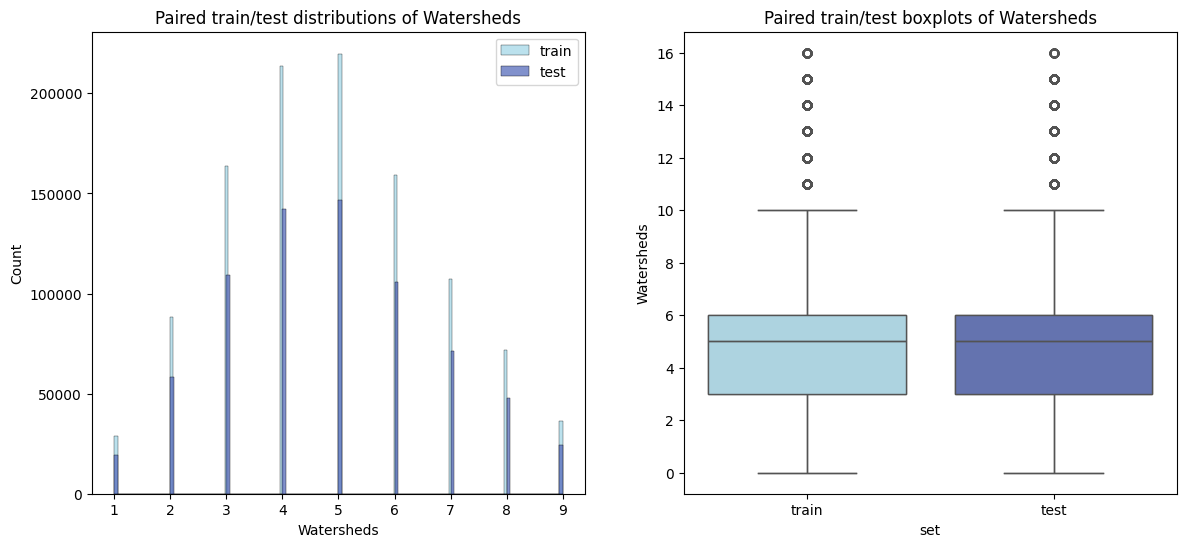

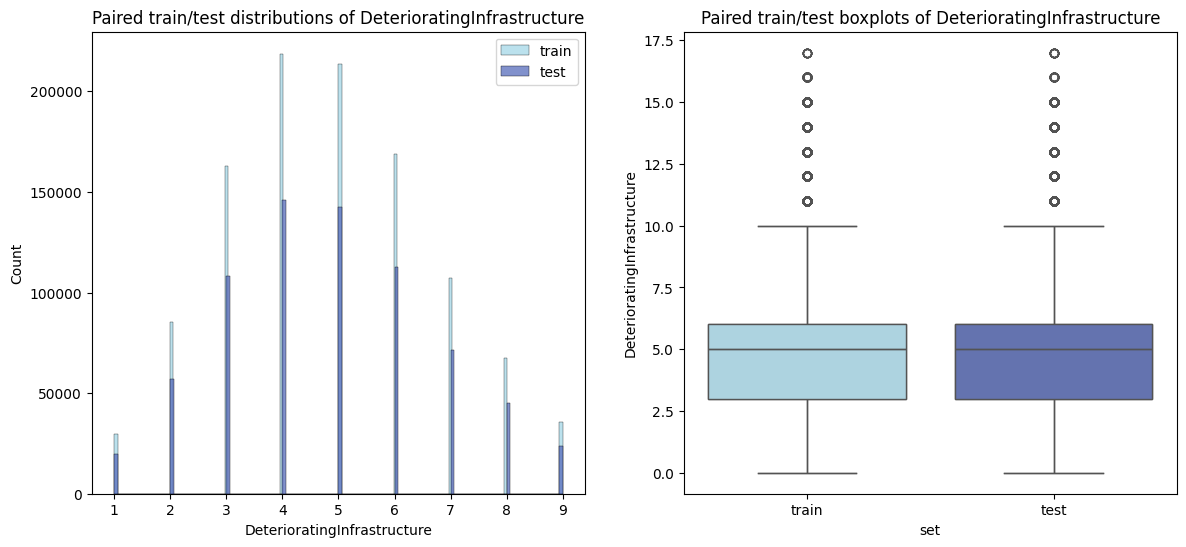

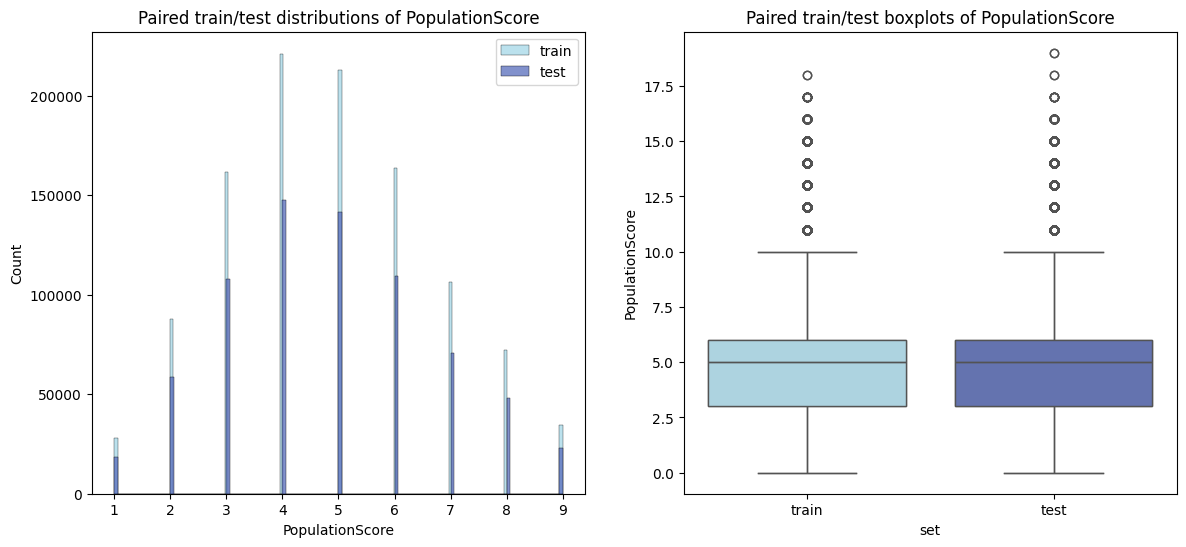

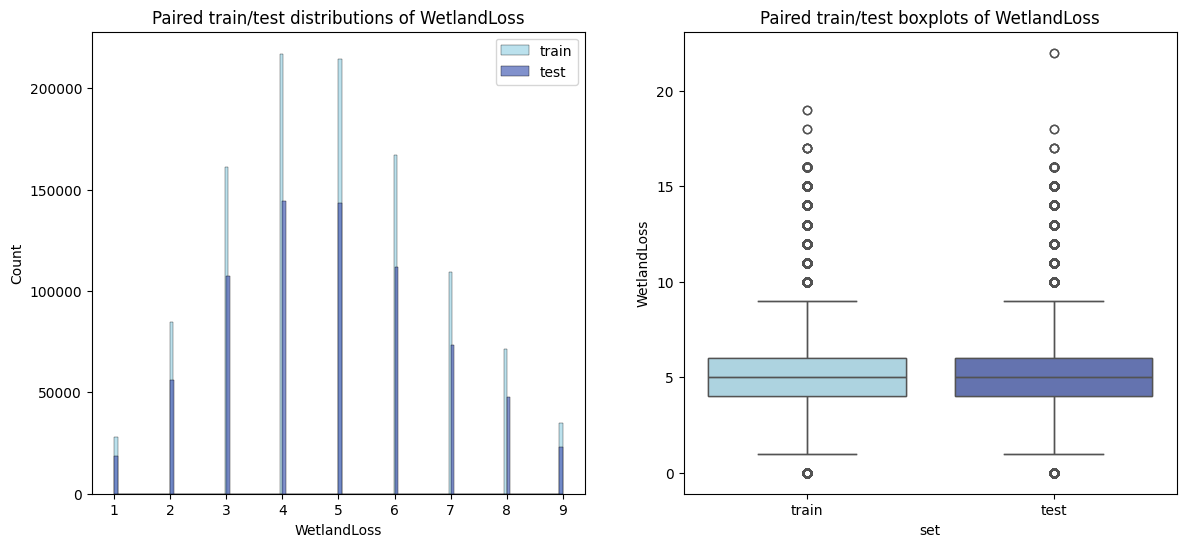

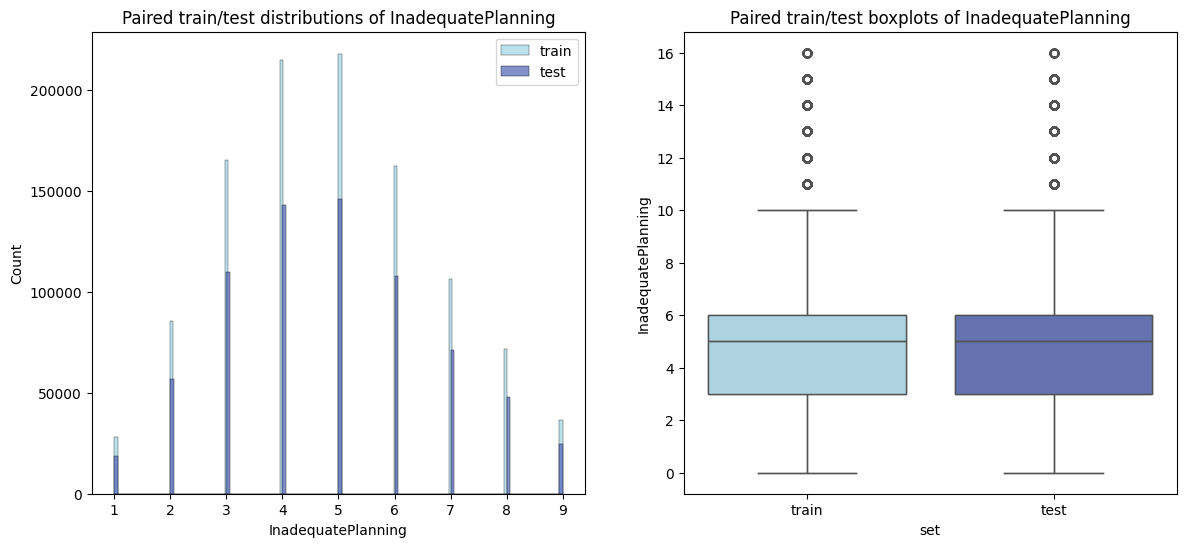

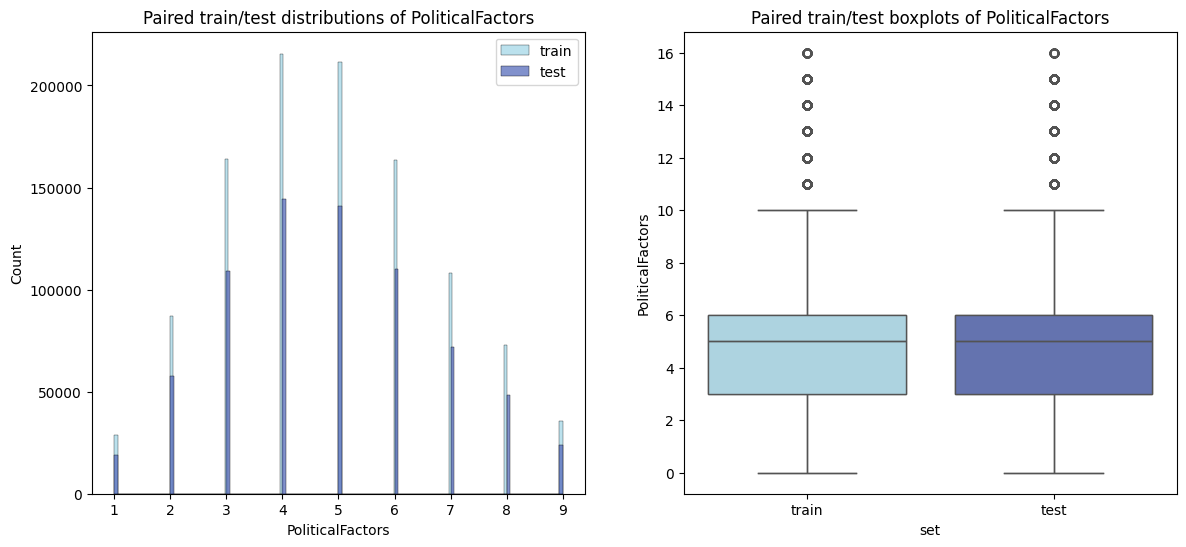

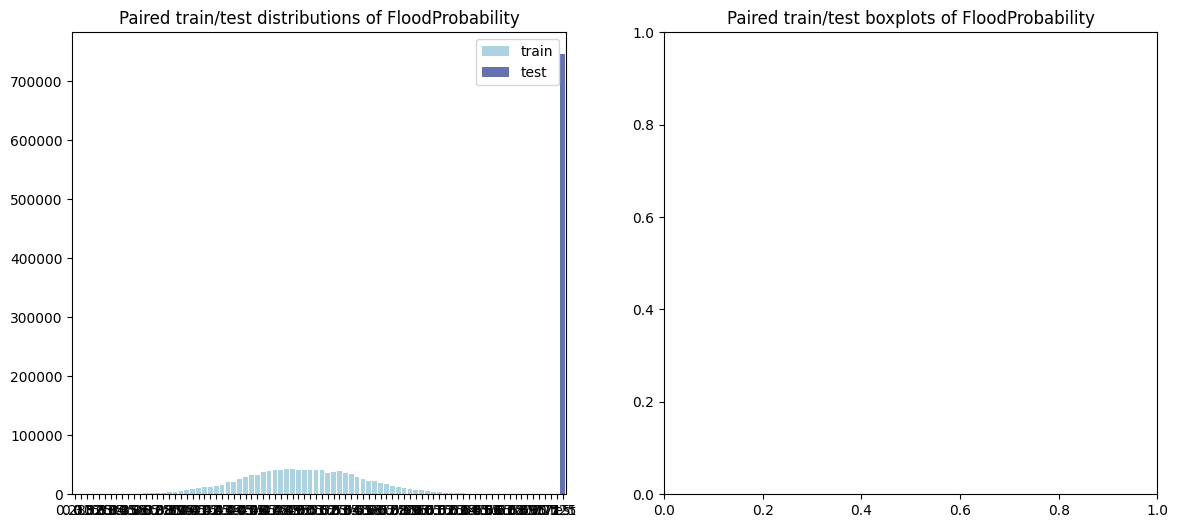

In [15]:
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df[hue] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        if selection.dtype.name != "object":
            q_025, q_975 = np.percentile(selection, [2.5, 97.5])
            selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            if data_df[feature].dtype.name == "object":
                sns.barplot(x=selection.value_counts().index.to_list(), y=selection.value_counts().values, color=palette[i], ax=axes[0], label=s)
                # plt.pie(data_df[[feature, "set"]].value_counts().values, labels=data_df[[feature, "set"]].value_counts().index, autopct='%1.1f%%', colors=palette, startangle=90, counterclock=False)
                sns.boxplot(x=hue, y=feature, data=pd.DataFrame({hue: [], feature: []}), palette=palette, ax=axes[1])
            else:
                sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
                sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    if data_df[feature].dtype.name != "object":
        axes[1].set_title(f"Paired train/test boxplots of {feature}")
    else:
        # axes[1].set_title(f"Paired train/test pie charts of {feature}")
        axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    #axes[1].legend()
    plt.show()

color_list = ["#A5D7E8", "#576CBC", "#10376D", "#003447"]
for feature in train.columns:
    plot_distribution_pairs(train, test, feature, palette=color_list)

<Axes: >

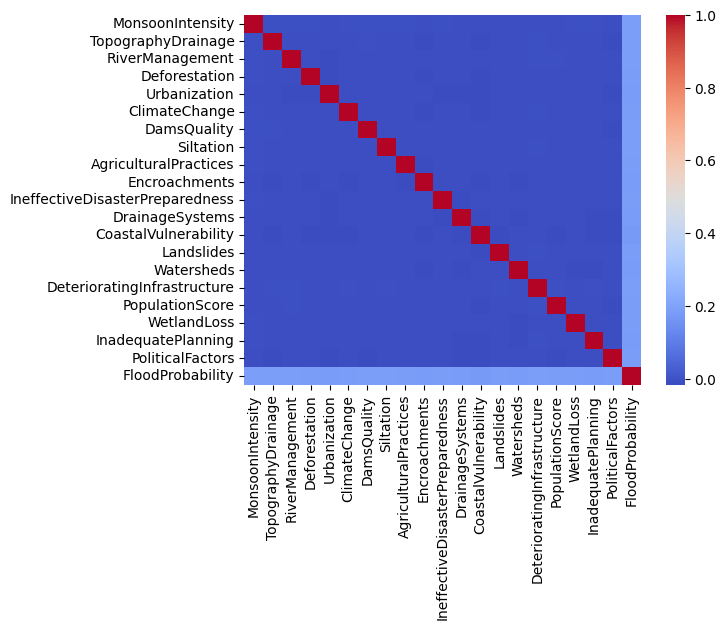

In [21]:
sns.heatmap(train.drop("id", axis=1).corr(), annot=False, fmt=".2f", cmap="coolwarm")

<Axes: >

c:\Users\ivan.trujillo_blueta\proyectos\personal\flood_prediction\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ivan.trujillo_blueta\proyectos\personal\flood_prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


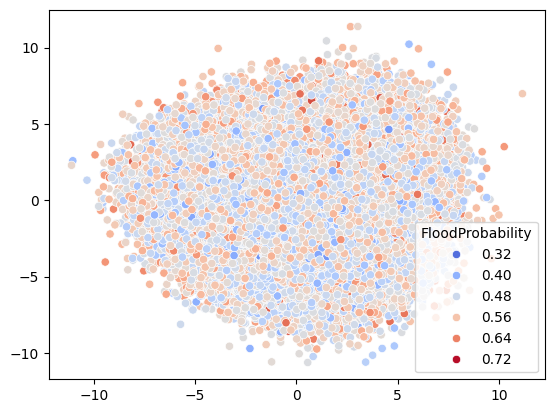

In [24]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train.drop("id", axis=1))
sns.scatterplot(x=train_pca[:, 0], y=train_pca[:, 1], hue=train["FloodProbability"], palette="coolwarm")

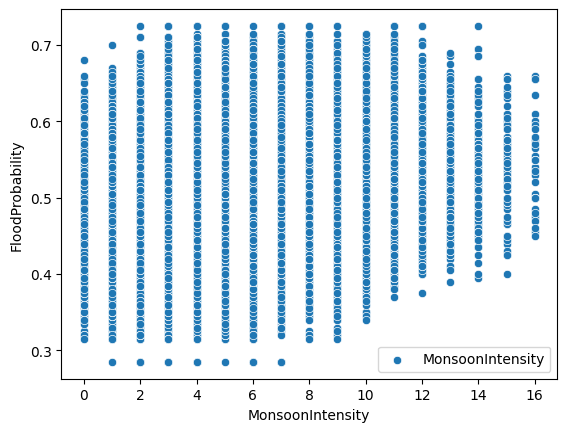

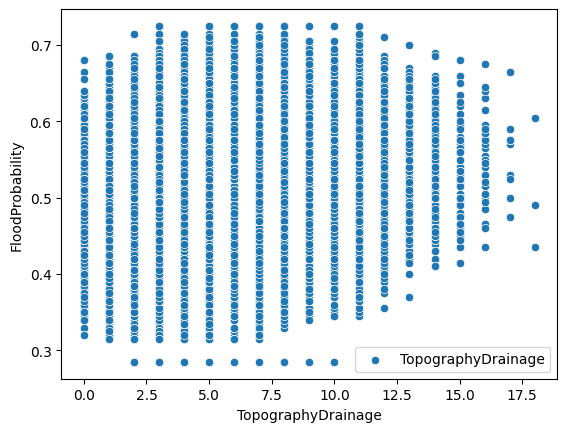

c:\Users\ivan.trujillo_blueta\proyectos\personal\flood_prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


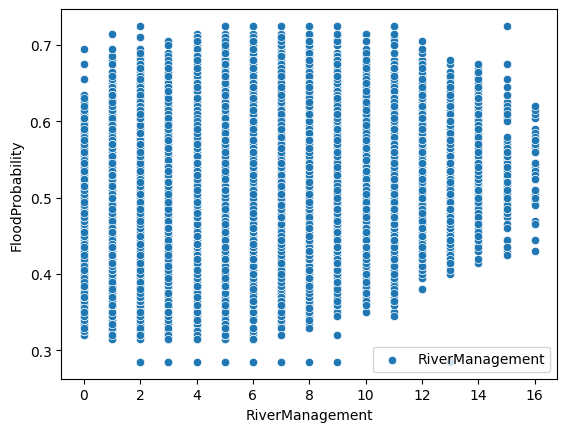

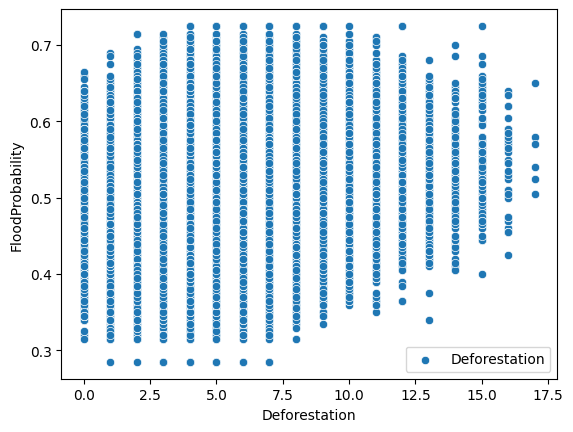

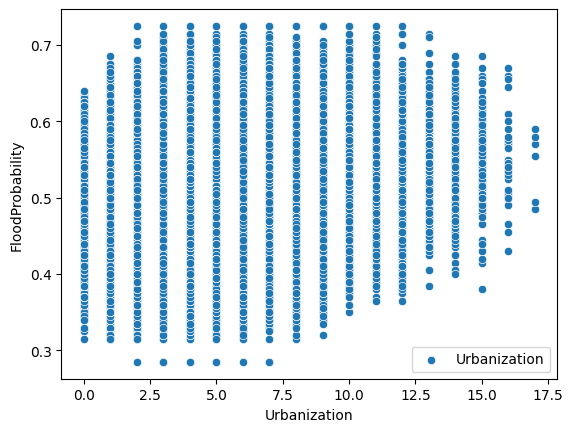

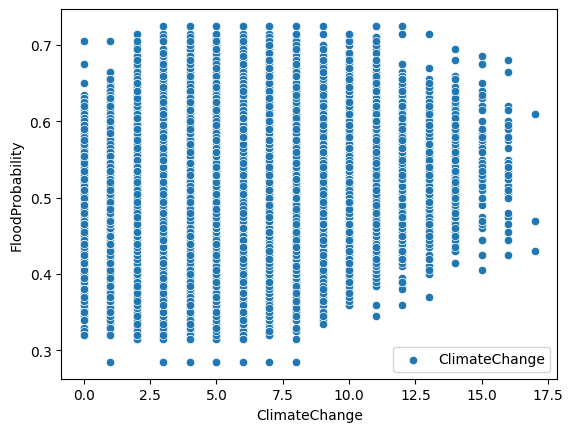

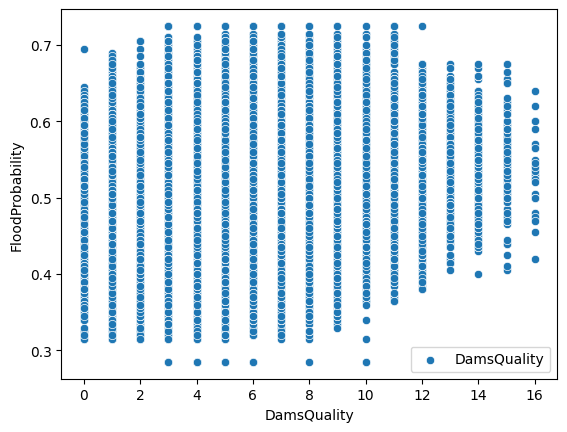

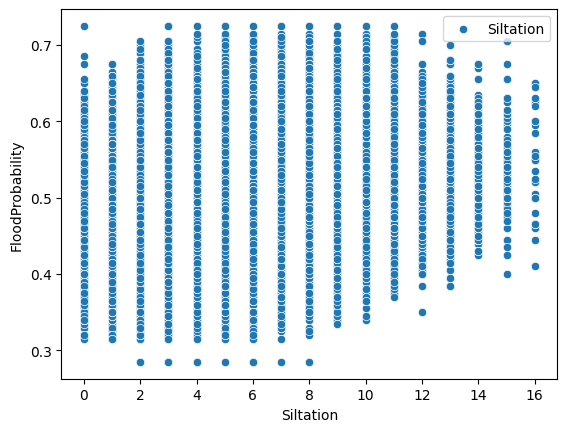

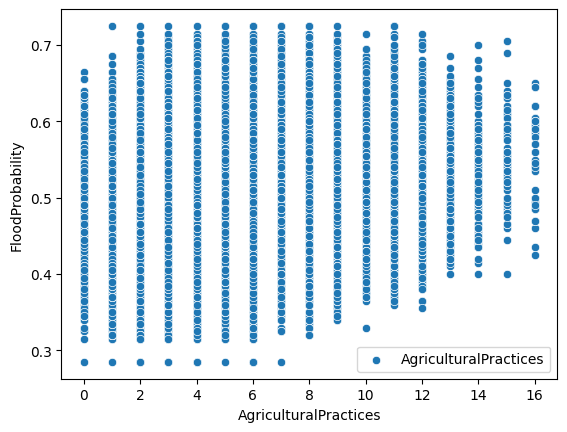

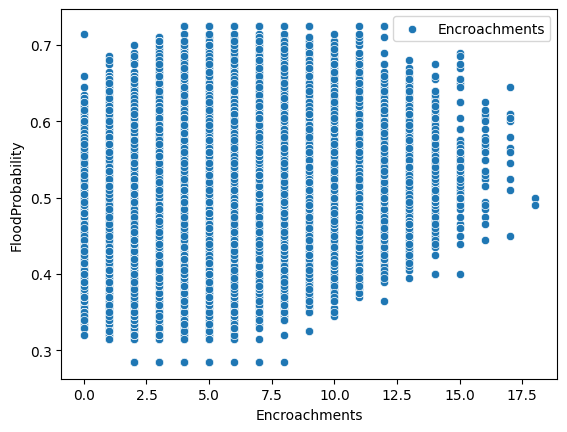

c:\Users\ivan.trujillo_blueta\proyectos\personal\flood_prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


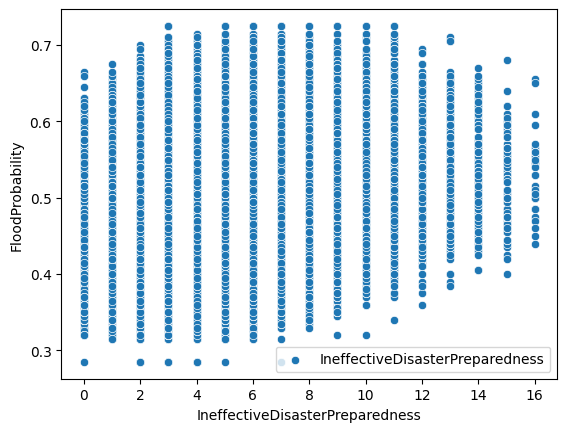

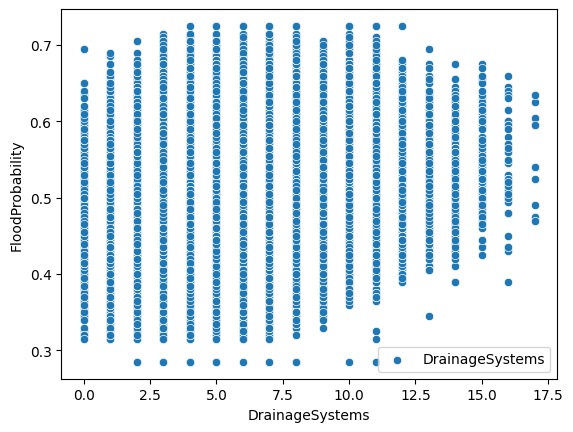

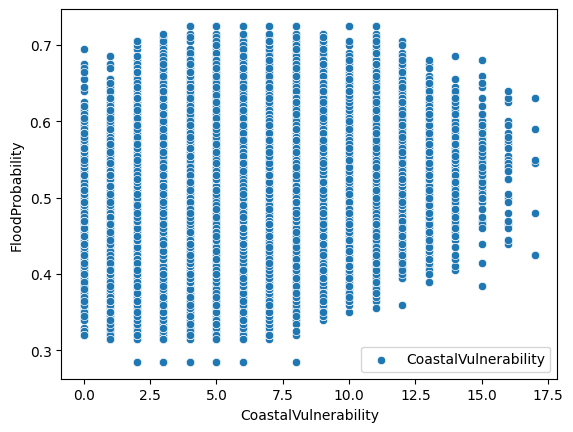

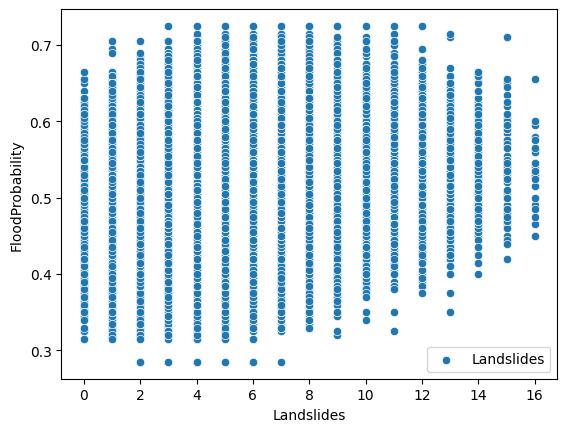

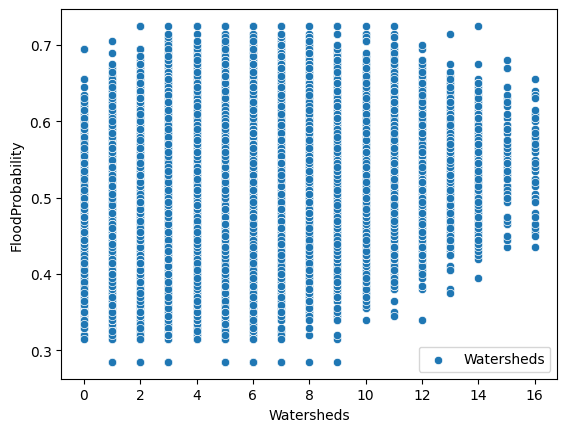

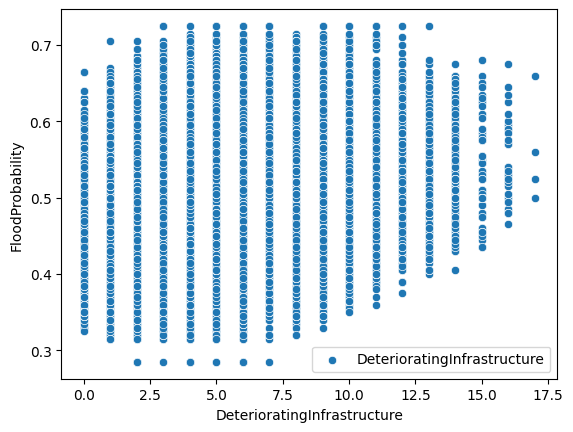

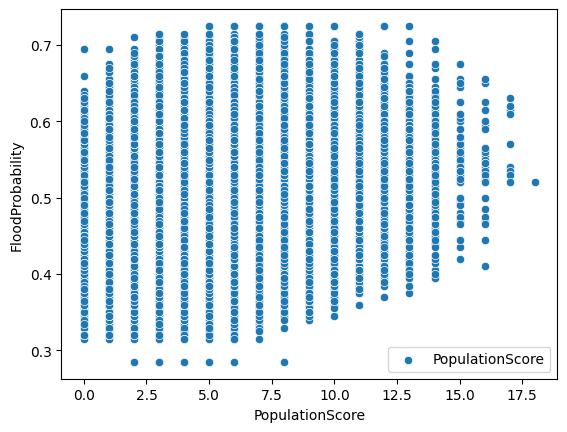

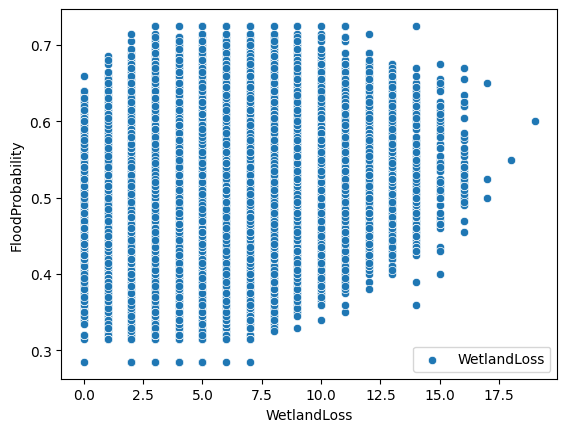

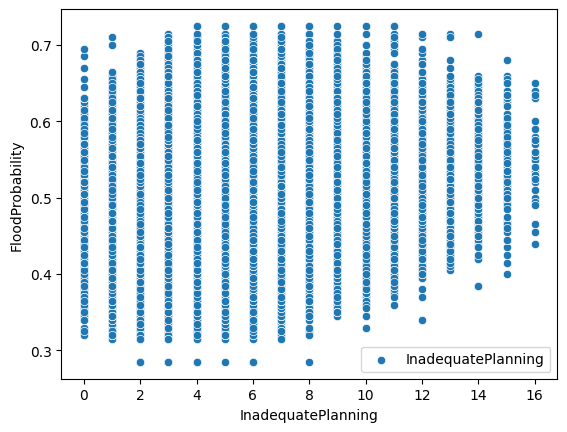

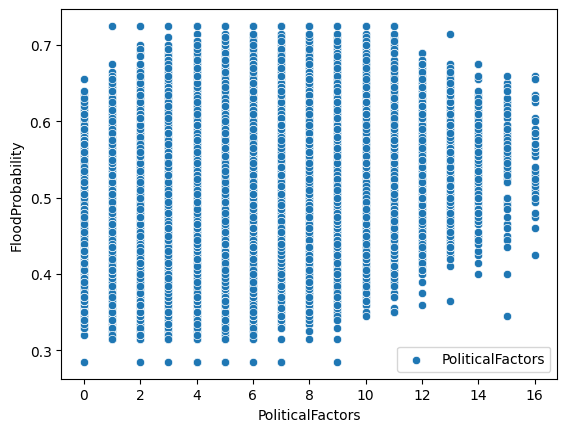

In [29]:
for col in train.drop(["id", "FloodProbability"], axis=1).columns:
    sns.scatterplot(x=col, y="FloodProbability", data=train, label=col)
    plt.show()

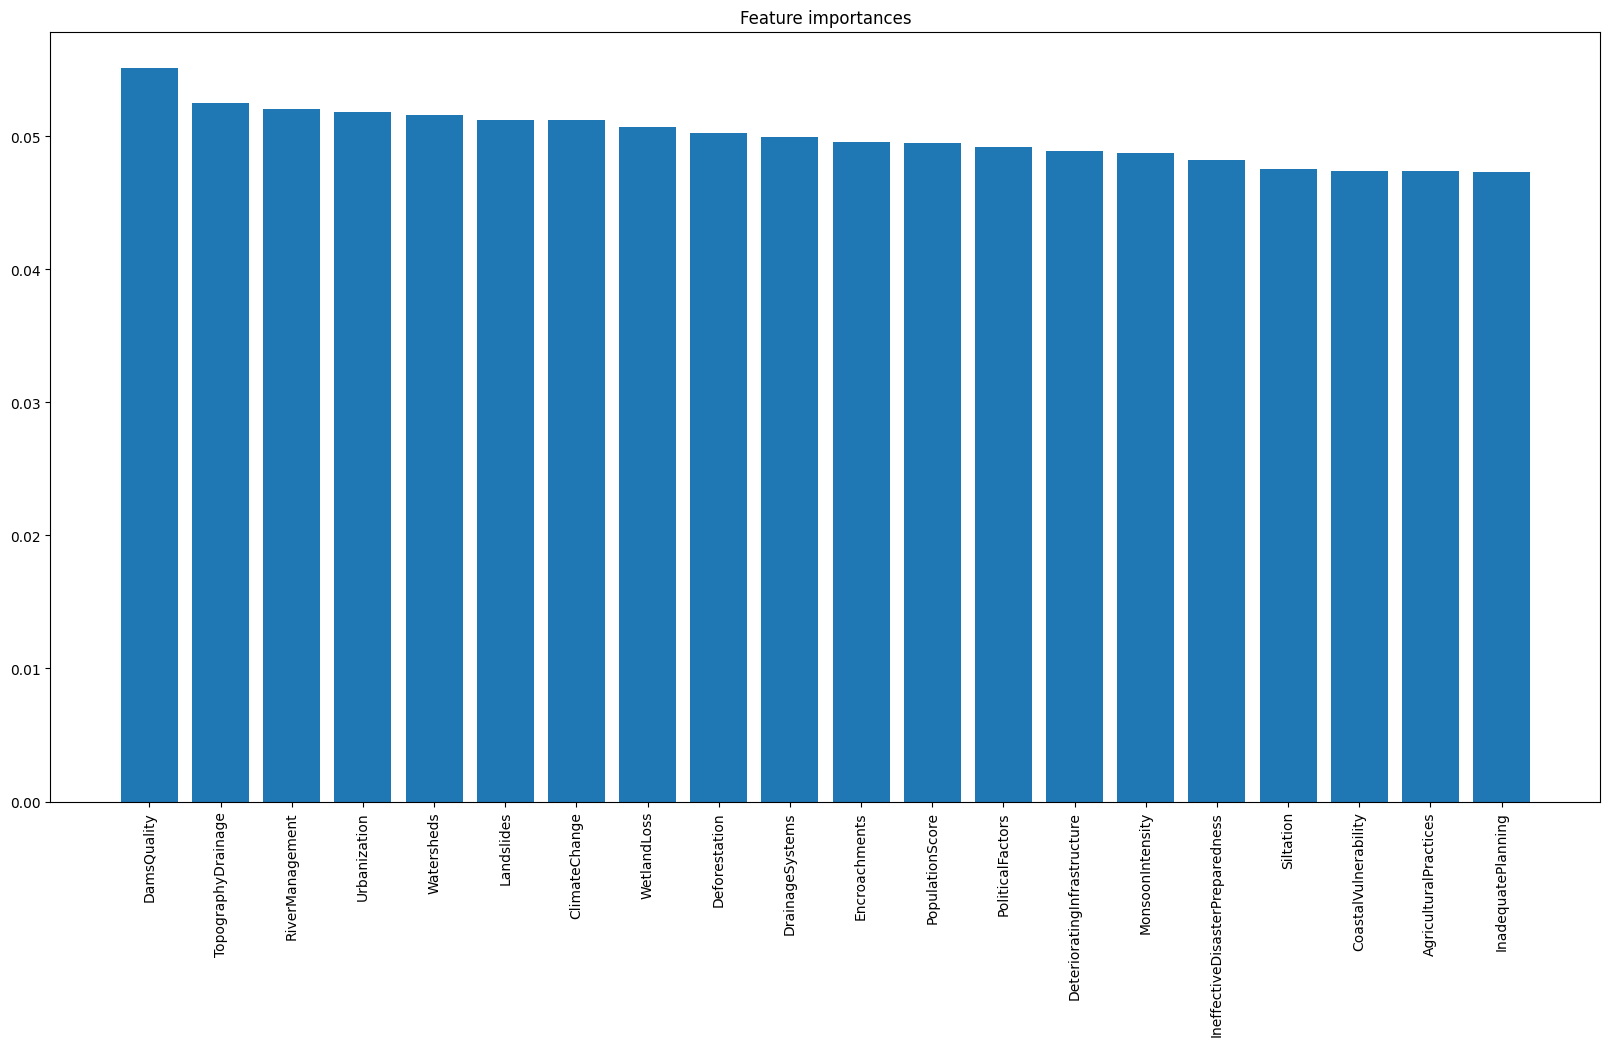

In [33]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
sample_train = train.drop(["id"], axis=1).sample(10000, random_state=42)
random_forest.fit(sample_train.drop(["FloodProbability"], axis=1), sample_train["FloodProbability"])
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(train.drop(["id", "FloodProbability"], axis=1).columns[indices], importances[indices])
plt.xticks(rotation=90)
plt.show()

In [34]:
train.shape, train.drop_duplicates().shape

((1117957, 22), (1117957, 22))

In [3]:
train = train.drop("id", axis=1)

In [4]:
initial_features = train.drop("FloodProbability", axis=1).columns

In [5]:
train["sum"] = train.drop("FloodProbability", axis=1).sum(axis=1)
test["sum"] = test.drop("id", axis=1).sum(axis=1)

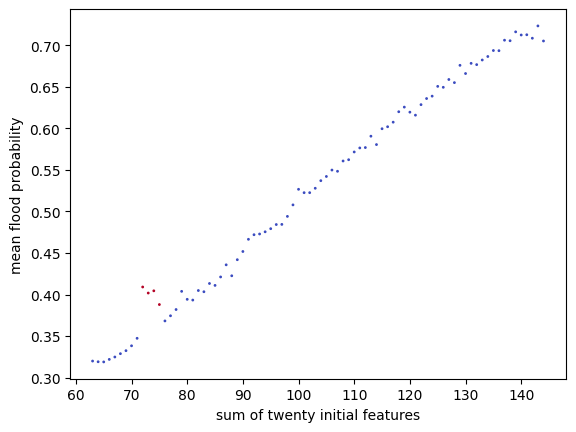

In [13]:
temp = train["FloodProbability"].groupby(train[initial_features].sum(axis=1)).mean()
plt.scatter(temp.index, temp, s=1, c=(temp.index.isin(np.arange(72, 76))), cmap='coolwarm')
plt.xlabel('sum of twenty initial features')
plt.ylabel('mean flood probability')
plt.show()

In [6]:
train["special_sum"] = train["sum"].apply(lambda x: 1 if x < 77 and x > 71 else 0)
test["special_sum"] = test["sum"].apply(lambda x: 1 if x < 77 and x > 71 else 0)

In [7]:
sorted_features = [f"sort_{i}" for i in np.arange(len(initial_features))]
for df in [train, test]:
    df[sorted_features] = np.sort(df[initial_features], axis=1)

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
target_name = "FloodProbability"

In [10]:
run_optimization = True

def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        
    }
    
    params['booster'] = 'gbtree'
    params['objective'] = 'reg:squarederror'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "hist"

    cv_splits = cv.split(train.drop(target_name, axis=1), y=train[target_name])
    cv_scores = list()

    for train_idx, val_idx in cv_splits:
    
        xgb_model = xgb.XGBRegressor(**params)

        X_train_fold, X_val_fold = train.drop(target_name, axis=1).iloc[train_idx], train.drop(target_name, axis=1).iloc[val_idx]
        target = train[target_name].to_numpy()
        y_train_fold, y_val_fold = target[train_idx], target[val_idx]

        xgb_model.fit(X_train_fold, y_train_fold)

        y_val_pred = xgb_model.predict(X_val_fold)
        cv_scores.append(r2_score(y_val_fold, y_val_pred))

    cv_evaluation = np.mean(cv_scores)
    
    return cv_evaluation

if run_optimization:
    
    sqlite_db = "sqlite:///sqlite.db"
    study_name = "flood_prediction_xgb"
    xgb_study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=10, seed=0),
                                direction="maximize", load_if_exists=True)

    xgb_study.optimize(objective, n_trials=100)
    best_xgb_params = xgb_study.best_params
    best_xgb_value = xgb_study.best_value

else:
    
    best_xgb_value = 0.86908
    best_xgb_params = {
        'learning_rate': 0.011743326568079722, 
        'gamma': 0.0005785930631904699, 
        'max_depth': 9, 
        'min_child_weight': 6, 
        'subsample': 0.7058616990383677, 
        'colsample_bytree': 0.9324808655218808, 
        'grow_policy': 'depthwise', 
        'n_estimators': 507, 
        'reg_lambda': 0.18912482826388546, 
        'reg_alpha': 1.617842884678693e-07
    }

print(f"best optmized accuracy: {best_xgb_value:0.5f}")
print(f"best hyperparameters: {best_xgb_params}")

best_xgb_params['booster'] = 'gbtree'
best_xgb_params['objective'] = 'reg:squarederror'
best_xgb_params['tree_method'] = "hist"
best_xgb_params["device"] = "cuda"
best_xgb_params["verbosity"] = 0

[I 2024-05-09 14:31:56,143] A new study created in RDB with name: flood_prediction_xgb
[I 2024-05-09 14:33:22,460] Trial 0 finished with value: 0.8622320815614934 and parameters: {'learning_rate': 0.12520653814999466, 'gamma': 0.35759468347102036, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.5965583595372332, 'colsample_bytree': 0.7521258791466592, 'grow_policy': 'lossguide', 'n_estimators': 968, 'reg_lambda': 1.65141683303417e-05, 'reg_alpha': 0.5116528751408895}. Best is trial 0 with value: 0.8622320815614934.
[I 2024-05-09 14:34:33,161] Trial 1 finished with value: 0.8570215046727503 and parameters: {'learning_rate': 0.11423254155608371, 'gamma': 0.2840222809789216, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.3609905097910785, 'colsample_bytree': 0.314152878208228, 'grow_policy': 'depthwise', 'n_estimators': 883, 'reg_lambda': 58.18375750787099, 'reg_alpha': 0.6176525039559425}. Best is trial 0 with value: 0.8622320815614934.
[I 2024-05-09 14:35:04,202] Trial 2 f

best optmized accuracy: 0.86908
best hyperparameters: {'learning_rate': 0.011743326568079722, 'gamma': 0.0005785930631904699, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7058616990383677, 'colsample_bytree': 0.9324808655218808, 'grow_policy': 'depthwise', 'n_estimators': 507, 'reg_lambda': 0.18912482826388546, 'reg_alpha': 1.617842884678693e-07}


In [11]:
run_optimization = True

def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'depth': trial.suggest_int('depth', 0, 12),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 1e-9, 0.5),
        # On GPU grow policy Lossguide can't be used with ordered boosting
        'grow_policy': trial.suggest_categorical('grow_policy', ["Depthwise", "Lossguide", "SymmetricTree"]),
        # 'grow_policy': trial.suggest_categorical('grow_policy1', ["Depthwise", "SymmetricTree"]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        # rsm on GPU is supported for pairwise modes only
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1.0, log=True)
    
    params['objective'] = 'RMSE'
    # params["task_type"] = "GPU"
    params["task_type"] = "CPU"
    params["devices"] = "0"
    params["verbose"] = 0

    cv_splits = cv.split(train.drop(target_name, axis=1), y=train[target_name])
    cv_scores = list()

    for train_idx, val_idx in cv_splits:
        gbm = cb.CatBoostRegressor(**params)

        X_train_fold, X_val_fold = train.drop(target_name, axis=1).iloc[train_idx], train.drop(target_name, axis=1).iloc[val_idx]
        target = train[target_name].to_numpy()
        y_train_fold, y_val_fold = target[train_idx], target[val_idx]

        # callbacks are not supported for GPU
        # pruning_callback = CatBoostPruningCallback(trial, "RMSE")
        gbm.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=0,
            early_stopping_rounds=100,
            # callbacks=[pruning_callback],
        )

        # evoke pruning manually.
        # pruning_callback.check_pruned()

        preds = gbm.predict(X_val_fold)
        r2 = r2_score(y_val_fold, preds)
        cv_scores.append(r2)
    
    return np.mean(cv_scores)

if run_optimization:
    
    sqlite_db = "sqlite:///sqlite.db"
    study_name = "flood_prediction_cb"
    cb_study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=10, seed=0),
                                direction="maximize", load_if_exists=True,
                                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
                                )

    cb_study.optimize(objective, n_trials=100)
    best_cb_params = cb_study.best_params
    best_cb_value = cb_study.best_value

else:
    
    best_cb_value = 0.86755
    best_cb_params = {
        'iterations': 923, 
        'learning_rate': 0.14518872586665998, 
        'depth': 6, 
        'l2_leaf_reg': 0.08672683316750412, 
        'grow_policy': "SymmetricTree", 
        'min_child_samples': 9, 
        'colsample_bylevel': 0.09986920017104892, 
        'bootstrap_type': "MVS",
        # 'subsample': 0.36986612821028797,
    }

print(f"best optmized accuracy: {best_cb_value:0.5f}")
print(f"best hyperparameters: {best_cb_params}")

best_cb_params['objective'] = 'RMSE'
# best_cb_params["task_type"] = "GPU"
best_cb_params["task_type"] = "CPU"
best_cb_params["devices"] = "0"

[I 2024-05-09 16:23:30,253] A new study created in RDB with name: flood_prediction_cb
[I 2024-05-09 16:27:59,189] Trial 0 finished with value: 0.8622719924030406 and parameters: {'iterations': 594, 'learning_rate': 0.269388301928541, 'depth': 7, 'l2_leaf_reg': 0.27244159195356527, 'grow_policy': 'Lossguide', 'min_child_samples': 9, 'colsample_bylevel': 0.0919735099256812, 'bootstrap_type': 'Bernoulli', 'subsample': 0.36986612821028797}. Best is trial 0 with value: 0.8622719924030406.
[I 2024-05-09 16:29:45,246] Trial 1 finished with value: 0.8283589474590827 and parameters: {'iterations': 933, 'learning_rate': 0.013869861245357327, 'depth': 1, 'l2_leaf_reg': 0.010109199699944461, 'grow_policy': 'SymmetricTree', 'min_child_samples': 10, 'colsample_bylevel': 0.0629736062312697, 'bootstrap_type': 'Bernoulli', 'subsample': 0.436436456821403}. Best is trial 0 with value: 0.8622719924030406.
[I 2024-05-09 16:30:21,895] Trial 2 finished with value: 0.7542027133996354 and parameters: {'iterati

best optmized accuracy: 0.86755
best hyperparameters: {'iterations': 923, 'learning_rate': 0.14518872586665998, 'depth': 6, 'l2_leaf_reg': 0.08672683316750412, 'grow_policy': 'SymmetricTree', 'min_child_samples': 9, 'colsample_bylevel': 0.09986920017104892, 'bootstrap_type': 'MVS'}


In [12]:
optuna.visualization.plot_optimization_history(cb_study)

In [13]:
optuna.visualization.plot_parallel_coordinate(cb_study)

[W 2024-05-09 21:58:33,278] Your study has only completed trials with missing parameters.


In [14]:
optuna.visualization.plot_slice(cb_study)

In [15]:
run_optimization = True

def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    train_x, valid_x, train_y, valid_y = train_test_split(train.drop(target_name, axis=1), train[target_name], test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    lgb_model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        # callbacks=[pruning_callback]
        )

    preds = lgb_model.predict(valid_x)
    r2 = r2_score(valid_y, preds)
    
    return r2

if run_optimization:
    
    sqlite_db = "sqlite:///sqlite.db"
    study_name = "flood_prediction_lgb"
    lgb_study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=10, seed=0),
                                direction="maximize", load_if_exists=True,
                                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
                                )

    lgb_study.optimize(objective, n_trials=100)
    best_lgb_params = lgb_study.best_params
    best_lgb_value = lgb_study.best_value

else:
    
    best_lgb_value = 0.86994
    best_lgb_params = {
        'objective': "regression",
        'metric': "rmse",
        'verbosity': -1,
        "boosting_type": "gbdt",
        'lambda_l1': 0.12348960646405413,
        'lambda_l2': 1.2660240759955491e-05, 
        'num_leaves': 88, 
        'feature_fraction': 0.9778363005190149, 
        'bagging_fraction': 0.9991915985366586, 
        'bagging_freq': 7, 
        'min_child_samples': 30,
    }

print(f"best optmized accuracy: {best_lgb_value:0.5f}")
print(f"best hyperparameters: {best_lgb_params}")

[I 2024-05-09 21:58:33,755] A new study created in RDB with name: flood_prediction_lgb
[I 2024-05-09 21:58:39,729] Trial 0 finished with value: 0.8675214514847358 and parameters: {'lambda_l1': 0.0008696040132105586, 'lambda_l2': 0.027334069690310565, 'num_leaves': 155, 'feature_fraction': 0.7269299097981381, 'bagging_fraction': 0.6541928796033428, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 0 with value: 0.8675214514847358.
[I 2024-05-09 21:58:46,097] Trial 1 finished with value: 0.8684587400764726 and parameters: {'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881, 'num_leaves': 99, 'feature_fraction': 0.8750350228495988, 'bagging_fraction': 0.7173369518517427, 'bagging_freq': 4, 'min_child_samples': 93}. Best is trial 1 with value: 0.8684587400764726.
[I 2024-05-09 21:58:50,442] Trial 2 finished with value: 0.8663112377633663 and parameters: {'lambda_l1': 4.3583742877412676e-08, 'lambda_l2': 6.083642669826052e-08, 'num_leaves': 7, 'feature_fraction': 0.899

best optmized accuracy: 0.86994
best hyperparameters: {'lambda_l1': 0.12348960646405413, 'lambda_l2': 1.2660240759955491e-05, 'num_leaves': 88, 'feature_fraction': 0.9778363005190149, 'bagging_fraction': 0.9991915985366586, 'bagging_freq': 7, 'min_child_samples': 30}


In [17]:
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb.XGBRegressor(**best_xgb_params)), ('cb', cb.CatBoostRegressor(**best_cb_params)), ('lgb', lgb.LGBMRegressor(**best_lgb_params))],
    final_estimator=LinearRegression(),
    cv=10
)

In [18]:
stacking_model.fit(train.drop(target_name, axis=1), train[target_name])

0:	learn: 0.0458798	total: 73.2ms	remaining: 1m 7s
1:	learn: 0.0417818	total: 141ms	remaining: 1m 4s
2:	learn: 0.0377971	total: 202ms	remaining: 1m 2s
3:	learn: 0.0351897	total: 267ms	remaining: 1m 1s
4:	learn: 0.0320635	total: 343ms	remaining: 1m 2s
5:	learn: 0.0299316	total: 413ms	remaining: 1m 3s
6:	learn: 0.0281077	total: 485ms	remaining: 1m 3s
7:	learn: 0.0268031	total: 555ms	remaining: 1m 3s
8:	learn: 0.0256850	total: 629ms	remaining: 1m 3s
9:	learn: 0.0246844	total: 695ms	remaining: 1m 3s
10:	learn: 0.0237922	total: 755ms	remaining: 1m 2s
11:	learn: 0.0229770	total: 814ms	remaining: 1m 1s
12:	learn: 0.0224705	total: 871ms	remaining: 1m 1s
13:	learn: 0.0219654	total: 929ms	remaining: 1m
14:	learn: 0.0215488	total: 989ms	remaining: 59.9s
15:	learn: 0.0212648	total: 1.05s	remaining: 59.5s
16:	learn: 0.0209522	total: 1.11s	remaining: 59s
17:	learn: 0.0207245	total: 1.17s	remaining: 58.8s
18:	learn: 0.0204664	total: 1.23s	remaining: 58.4s
19:	learn: 0.0202915	total: 1.29s	remaining: 

StackingRegressor(cv=10,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9324808655218808,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.0005785930631904699,
                                            grow_policy='depthwise',
                                            importance_...
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('cb',
                               <catboost.core.CatBoostRegressor object at 0x000001C7EA0E98E0>),
                              ('lgb',
                               LGBMRegressor(bagging_fraction=0.9991915985366586,
                                             bagging_freq=7,
                                             feature_fraction=0.9778363005190149,
                                             lambda_l1=0.12348960646405413,
                                             lambda_l2=1.2660240759955491e-05,
                                             min_child_samples=30,
                                             num_leaves=88))],
                  final_estimator=LinearRegression())

In [19]:
stacking_preds = stacking_model.predict(train.drop(target_name, axis=1))

[LightGBM] [Warning] feature_fraction is set=0.9778363005190149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9778363005190149
[LightGBM] [Warning] lambda_l1 is set=0.12348960646405413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12348960646405413
[LightGBM] [Warning] lambda_l2 is set=1.2660240759955491e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2660240759955491e-05
[LightGBM] [Warning] bagging_fraction is set=0.9991915985366586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991915985366586
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [20]:
r2_score(train[target_name], stacking_preds)

0.8716332576737895

First: 0.8461314831554089

Second: 0.873984731995088

Third: 0.8716332576737895

In [21]:
submission = test.copy()

In [22]:
submission["FloodProbability"] = stacking_model.predict(submission.drop("id", axis=1))

[LightGBM] [Warning] feature_fraction is set=0.9778363005190149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9778363005190149
[LightGBM] [Warning] lambda_l1 is set=0.12348960646405413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12348960646405413
[LightGBM] [Warning] lambda_l2 is set=1.2660240759955491e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2660240759955491e-05
[LightGBM] [Warning] bagging_fraction is set=0.9991915985366586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991915985366586
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [23]:
submission = submission[['id', 'FloodProbability']]

In [24]:
submission.to_csv('data/submission.csv', index=False)